In [104]:
import shap
import pickle
import optuna

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna.distributions as D

from optuna.integration import OptunaSearchCV
from ydata_profiling import ProfileReport
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    f1_score,
    precision_recall_curve,
    roc_curve, 
    auc,
    make_scorer,
    mean_squared_error,
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor,
    Pool, 
    cv, 
    EShapCalcType, 
    EFeaturesSelectionAlgorithm
)


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 200)

In [105]:
def weighted_mean_absolute_error(y_true, y_pred, weights):

    '''

    Weighted mean absolute error.

    Parameters
    ----------
    y_true: ndarray
        Ground truth
    y_pred: ndarray
        Array of predictions

    Returns
    -------
    rmsle: float
        Weighted mean absolute error

    References
    ----------
    .. [1] https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html

    '''
    
    return (weights * np.abs(y_true - y_pred)).mean()

In [106]:
def fit_catboost(features_train, 
                 features_val, 
                 target_train, 
                 target_val, 
                 cat_features, 
                 n_iter=3000,
                 lr=0.02,
                 train_weight=None,
                 val_weight=None):
    
    pool_train = Pool(
        features_train,
        target_train,
        weight = train_weight,
        cat_features = cat_features
    )

    pool_val = Pool(
        features_val,
        target_val,
        weight = val_weight,
        cat_features = cat_features
    )

    model = CatBoostRegressor(
        iterations= n_iter,
        learning_rate=lr,
        loss_function='RMSE',
        random_seed=42,
        task_type='GPU'
    )

    model.fit(
        pool_train,
        eval_set=pool_val,
        verbose=100,
        plot=False
    )

    return model

In [107]:
full_train_df = pd.read_parquet('/kaggle/input/full-dataset-alfa/train.parquet')

train_df, test_df = train_test_split(
    full_train_df,
    test_size=0.3,
    random_state=42
)

In [108]:
clf_model_1 = CatBoostClassifier().load_model('/kaggle/input/alfa-clf-models/train_3cl_333_666_model_clf_1')
clf_model_2 = CatBoostClassifier().load_model('/kaggle/input/alfa-clf-models/train_3cl_333_666_model_clf_2')
clf_model_3 = CatBoostClassifier().load_model('/kaggle/input/alfa-clf-models/train_3cl_333_666_model_clf_3')

with open('/kaggle/input/alfa-clf-models/3cl_33_67_label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

train_df['target_bins'] = None
train_df.loc[train_df['target'] <= full_train_df['target'].quantile(0.333), 'target_bins'] = 'bin_0'
train_df.loc[
    (train_df['target'] > full_train_df['target'].quantile(0.333))
    & (train_df['target'] <= full_train_df['target'].quantile(0.666)), 
    'target_bins'
] = 'bin_1'
train_df.loc[train_df['target'] > full_train_df['target'].quantile(0.666), 'target_bins'] = 'bin_2'

train_df['target_bins'] = le.transform(train_df['target_bins'])

mean_pred_train = np.mean(
    np.concatenate(
        (
            clf_model_1.predict_proba(train_df[clf_model_1.feature_names_]).reshape(1, -1, 3),
            clf_model_2.predict_proba(train_df[clf_model_2.feature_names_]).reshape(1, -1, 3),
            clf_model_3.predict_proba(train_df[clf_model_3.feature_names_]).reshape(1, -1, 3)
        )
    ),
    axis=0
)

train_df['cl0_prob'] = mean_pred_train[:,0]
train_df['cl1_prob'] = mean_pred_train[:,1]
train_df['cl2_prob'] = mean_pred_train[:,2]

mean_pred_test = np.mean(
    np.concatenate(
        (
            clf_model_1.predict_proba(test_df[clf_model_1.feature_names_]).reshape(1, -1, 3),
            clf_model_2.predict_proba(test_df[clf_model_2.feature_names_]).reshape(1, -1, 3),
            clf_model_3.predict_proba(test_df[clf_model_3.feature_names_]).reshape(1, -1, 3)
        )
    ),
    axis=0
)

test_df['target_bins'] = np.argmax(mean_pred_test, axis=1)

test_df['cl0_prob'] = mean_pred_test[:,0]
test_df['cl1_prob'] = mean_pred_test[:,1]
test_df['cl2_prob'] = mean_pred_test[:,2]

test_df.head()

,client_id,feature_date,target,w,accum_rur_amt_cm_avg_div_v2,addrref,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__tovary_dlja_detej,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__turisticheskie_agenstva,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__marketplejsy,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__nalogi,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__ohota_i_rybalka,amount_by_category_90d__summarur_amt__sum__cashflowcategory_name__prochie_bilety,atravel,avg_3m_hotels,avg_6m_building_services,avg_6m_money_transactions,avg_6m_personal_services,avg_6m_transportation,avg_by_category__amount__sum__cashflowcategory_name__detskie_igrushki,avg_by_category__amount__sum__cashflowcategory_name__investitsii,avg_by_category__amount__sum__cashflowcategory_name__odezhda_dlja_beremennyh,avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate,avg_by_category__amount__sum__cashflowcategory_name__zdorove,avg_by_category__amount__sum__cashflowcategory_name__zooparki,avg_cnt_daily_transactions_90d,avg_debet_turn_rur,avg_percents_inc,bki_total_ip_max_limit,by_category__amount__sum__eoperation_type_name__perevod_mezhdu_svoimi_schetami,by_category__amount__sum__eoperation_type_name__platezh_cherez_vidzhet_moj_mobilnyj,by_category__amount__sum__eoperation_type_name__pokupka_paja,by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur,calls_weight_v2,card_dda_rur_amt_cm_avg_div_v2,cc_other_rate_max_2avg_prop,channel_agentskij_kanal_voc_features_12m_avg_mark,channel_agentskij_kanal_voc_features_12m_cnt_mark,channel_bankomaty_voc_features_36m_avg_mark,channel_bankomaty_voc_features_36m_voc_without_marks_portion,channel_bankomaty_voc_features_3m_mark_eq_5_flag,channel_bankomaty_voc_features_full_mark_eq_5_flag,channel_bankomaty_voc_features_full_voc_not_null_flag,channel_chat_s_operatorom_alfainvestitsii_voc_features_12m_avg_mark,channel_chat_s_operatorom_alfainvestitsii_voc_features_36m_mark_not_null_flag,channel_chat_s_operatorom_voc_features_12m_cnt_mark,channel_chat_s_operatorom_voc_features_12m_mark_eq_3_flag,channel_chat_s_operatorom_voc_features_12m_voc_with_expert_cnt,channel_chat_s_operatorom_voc_features_3m_mark_eq_4_flag,channel_chat_s_operatorom_voc_features_full_voc_without_marks_portion,channel_chatbot_alfainvestitsii_voc_features_12m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_12m_voc_with_expert_portion,channel_chatbot_alfainvestitsii_voc_features_36m_mark_eq_3_flag,channel_chatbot_alfainvestitsii_voc_features_36m_min_mark,channel_chatbot_alfainvestitsii_voc_features_3m_mark_eq_5_flag,channel_chatbot_alfainvestitsii_voc_features_3m_mark_in_4_5_flag,channel_chatbot_alfainvestitsii_voc_features_full_avg_mark,channel_chatbot_voc_features_12m_mark_in_1_3_flag,channel_chatbot_voc_features_12m_voc_with_expert_portion,channel_chatbot_voc_features_full_voc_without_marks_portion,channel_collection_voc_features_36m_cnt_mark,channel_collection_voc_features_36m_mark_eq_2_flag,channel_collection_voc_features_36m_voc_not_null_flag,channel_collection_voc_features_3m_voc_with_expert_portion,channel_collection_voc_features_full_voc_without_marks_portion,channel_finansovyj_sovetnik_voc_features_36m_avg_mark,channel_finansovyj_sovetnik_voc_features_3m_voc_with_expert_portion,channel_finansovyj_sovetnik_voc_features_full_avg_mark,channel_finansovyj_sovetnik_voc_features_full_voc_with_expert_cnt,channel_frodmonitoring_voc_features_12m_mark_eq_2_flag,channel_frodmonitoring_voc_features_12m_max_mark,channel_frodmonitoring_voc_features_3m_mark_in_4_5_flag,channel_frodmon

In [109]:
features = list(train_df.drop(['client_id', 'feature_date', 'target', 'w'], axis=1).columns)

cat_features = list(train_df[features].select_dtypes('object').columns)
num_features = list(set(features) - set(cat_features))

len(features), len(cat_features), len(num_features)

(273, 11, 262)

# Обучение модели

In [110]:
features_train = train_df[features]
features_val = test_df[features]
target_train = train_df['target']
target_val = test_df['target']
w_train = train_df['w']
w_val = test_df['w']

0:	learn: 153514.4332581	test: 153857.6938723	best: 153857.6938723 (0)	total: 32.4ms	remaining: 2m 9s
100:	learn: 135342.1217689	test: 137733.1051000	best: 137733.1051000 (100)	total: 2.37s	remaining: 1m 31s
200:	learn: 121464.4327696	test: 125964.3894825	best: 125964.3894825 (200)	total: 4.55s	remaining: 1m 25s
300:	learn: 111009.0844884	test: 117570.5129825	best: 117570.5129825 (300)	total: 6.86s	remaining: 1m 24s
400:	learn: 103244.8919811	test: 111723.8249486	best: 111723.8249486 (400)	total: 9.04s	remaining: 1m 21s
500:	learn: 97518.6714767	test: 107712.4174424	best: 107712.4174424 (500)	total: 11.1s	remaining: 1m 17s
600:	learn: 93321.1506251	test: 104997.5168322	best: 104997.5168322 (600)	total: 13.2s	remaining: 1m 14s
700:	learn: 90225.9585095	test: 103153.7686568	best: 103153.7686568 (700)	total: 15.3s	remaining: 1m 12s
800:	learn: 87938.4693892	test: 101906.1674282	best: 101906.1674282 (800)	total: 17.4s	remaining: 1m 9s
900:	learn: 86230.0977937	test: 101068.0177934	best: 10

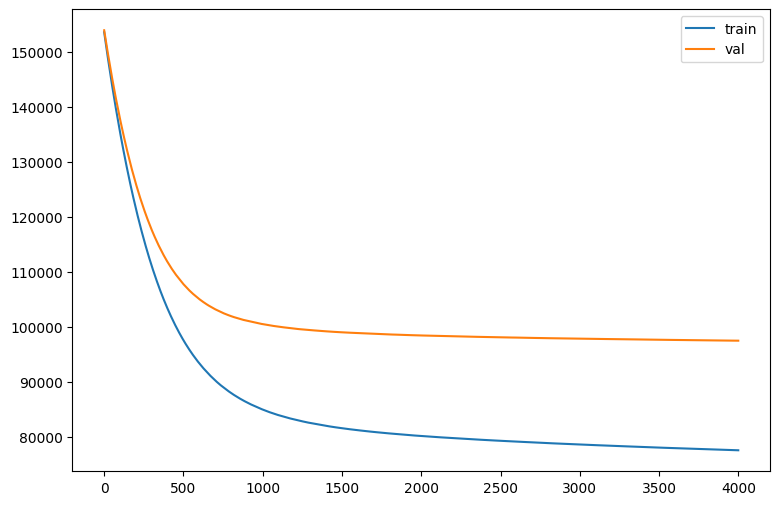

WMAE = 30575.98
Overfit: 19918.405102502962


In [114]:
model = fit_catboost(
    features_train,
    features_val, 
    target_train,
    target_val, 
    cat_features, 
    4000, 0.002,
    train_weight = w_train,
    val_weight = w_val
)
    
plt.figure(figsize=(9, 6))
plt.plot(range(0,len(model.evals_result_['learn']['RMSE'])),model.evals_result_['learn']['RMSE'], label = 'train')
plt.plot(range(0,len(model.evals_result_['learn']['RMSE'])),model.evals_result_['validation']['RMSE'], label = 'val')
plt.legend()
plt.show()

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

Text(0.5, 1.0, 'Residual Plot')

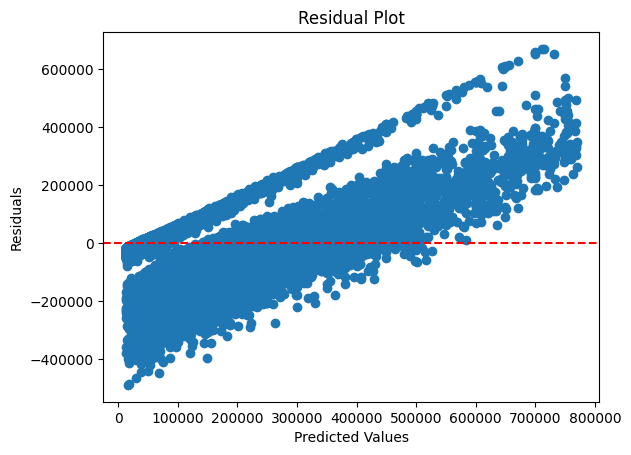

In [115]:
# Plot Residuals
residuals = target_val - model.predict(features_val)
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

/opt/conda/lib/python3.10/site-packages/shap/plots/_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



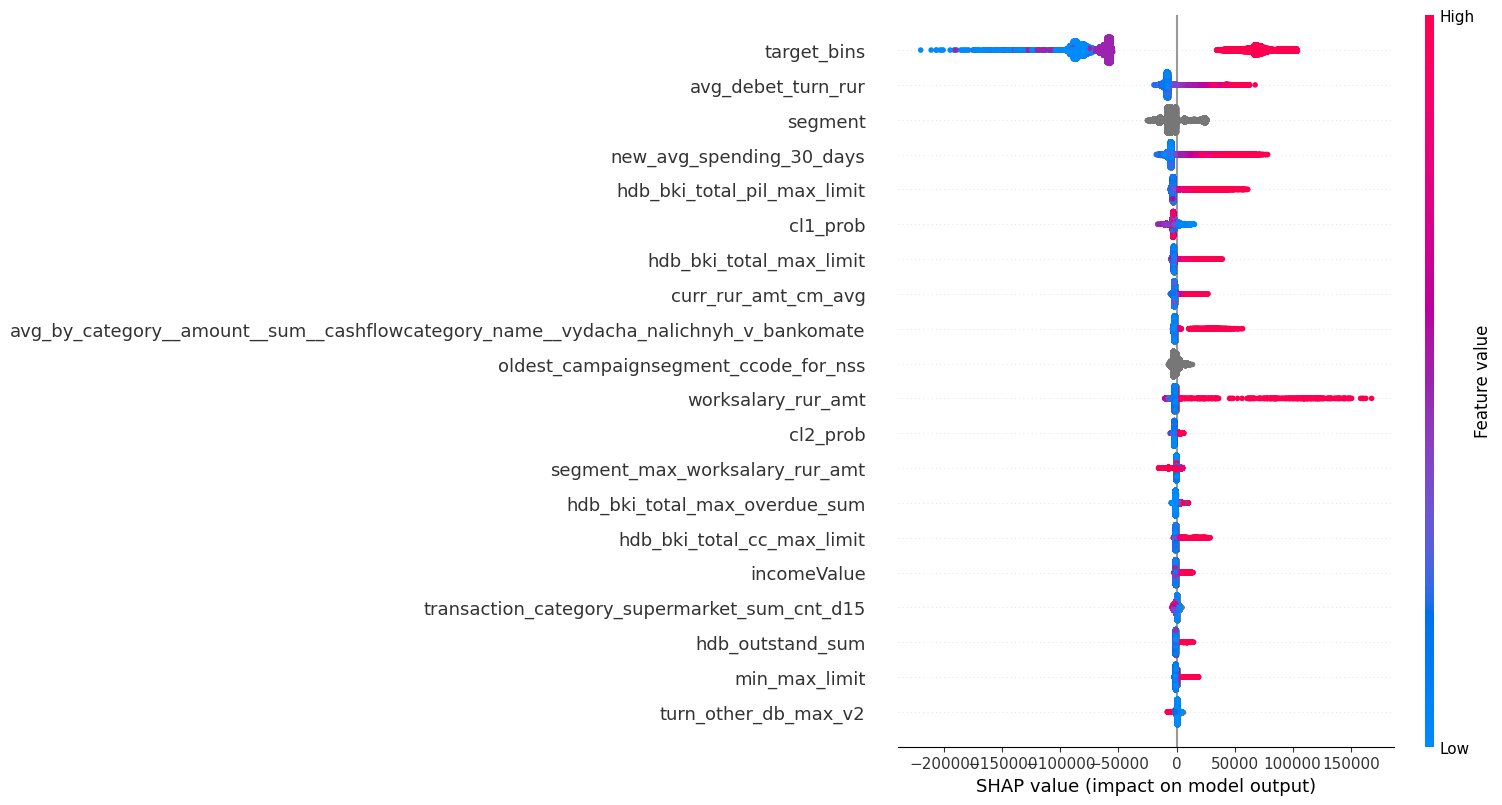

,feature,importance
0,target_bins,73157.544808
1,avg_debet_turn_rur,11497.605335
2,segment,8704.331279
3,new_avg_spending_30_days,8152.377815
4,hdb_bki_total_pil_max_limit,4498.600822


In [116]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val)
)
shap.summary_plot(shap_values, features_val)

shap_importance = (
    pd.DataFrame(
        {"feature":  features_train.columns, "importance": np.mean(np.abs(shap_values), axis=0)}
    ).sort_values("importance", ascending=False, ignore_index=True)
)
shap_importance.head()

# Факторный анализ

In [117]:
# по пропущенным значениям

def feats_filter_nan(df: pd.DataFrame,
                     num_feat: list,
                     cat_feat: list,
                     nan_threshold: float):

    """Функция отбора фичей по доле NaN-значений.
    Фичи, которые имеют долю NaN-значений не ниже заданного nan_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    num_feat : list
        список числовых фичей
    cat_feat : list
        список категориальных фичей (в нашем случае для них NaN-значением является 'miss_value')
    nan_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    # для числовых фичей
    nan_stats_num = (
        df[num_feat]
        .isna().mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )
    # для категориальных
    nan_stats_cat = (
        (df[cat_feat] == 'miss_value')
        .mean(axis=0)
        .reset_index()
        .rename(columns={0: 'nan_frac', 'index': 'col'})
    )

    nan_stats = pd.concat([nan_stats_num, nan_stats_cat])
    selected_features = list(nan_stats[nan_stats['nan_frac'] < nan_threshold]['col'])

    return selected_features


deleted_features = list(set(features) - set(feats_filter_nan(train_df, num_features, cat_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nan(train_df, num_features, cat_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
26,car_country,638.737971
37,first_salary_income,315.602807
49,hdb_bki_other_active_auto_month_payments_sum,152.185479
76,avg_by_category__amount__sum__cashflowcategory...,65.204926
83,brand,56.120761
88,transaction_category_hotels_sum_amt_d15,51.471729
94,unique_countries1,43.944105
98,part_last_position_ccode,35.792607
105,model,22.165886
107,min_cc_max_pilot_score_actoff_180d,18.795265


183

In [118]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:9]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

192

In [119]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    """Функция отбора фичей по доле самого частого значения.
    Фичи, которые имеют 1 уникальное значение (помимо NaN), либо для которых
      доля самого частого значения (включая NaN) не ниже unique_threshold, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    unique_threshold : float
        порог удаления фичи

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    selected_features = []

    for feat in features:
        if df[feat].nunique() >= 2 and df[feat].astype(str).value_counts(1).values[0] < unique_threshold:
            selected_features += [feat]

    return selected_features

deleted_features = list(set(selected_features) - set(feats_filter_nunique(train_df, selected_features, 0.95)))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = feats_filter_nunique(train_df, selected_features, 0.95)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

,feature,importance
26,car_country,638.737971
37,first_salary_income,315.602807
49,hdb_bki_other_active_auto_month_payments_sum,152.185479
76,avg_by_category__amount__sum__cashflowcategory...,65.204926
80,channel_otdelenija_voc_features_full_voc_not_n...,61.604580
83,brand,56.120761
88,transaction_category_hotels_sum_amt_d15,51.471729
94,unique_countries1,43.944105
98,part_last_position_ccode,35.792607
105,model,22.165886


175

In [120]:
selected_features += list(
    shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:10]
)
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

185

In [122]:
# отсечение по рандомной фиче

def feats_filter_random_feat(df: pd.DataFrame,
                             features: list,
                             cat_features: list):

    """Функция отбора фичей при помощи отсечения менее важных фичей чем рандомная фича.
    Фичи, которые имеют в простой модели важность ниже рандомной фичи, подлежат удалению.

    Parameters
    ----------
    df : pd.DataFrame
        датафрейм с фичами
    features : list
        список фичей
    cat_features : list
        список категориальных фичей

    Returns
    -------
    list
        список фичей, которые останутся в датафрейме

    """

    df['random'] = np.random.uniform(0, 1, df.shape[0])

    pool_train = Pool(
        df[features + ['random']],
        df['target'],
        cat_features = cat_features,
        weight = df['w']
    )

    simple_model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.002,
        loss_function='RMSE',
        random_seed = 42,
        task_type='GPU'
    )

    simple_model.fit(
        pool_train,
        verbose=100
    )

    shap_values = (
        shap
        .TreeExplainer(simple_model)
        .shap_values(df[features + ['random']])
    )

    model_importance = (
        pd.DataFrame(
            {"feature":  features + ['random'], "importance": np.mean(np.abs(shap_values), axis=0)}
        ).sort_values("importance", ascending=False, ignore_index=True)
    )

    selected_features = list(
        model_importance[
            model_importance['importance'] 
            > model_importance.loc[model_importance['feature'] == 'random', 'importance'].values[0]
        ]['feature']
    )

    return selected_features


_selected_features = feats_filter_random_feat(train_df, selected_features, selected_features_cat)
deleted_features = list(set(selected_features) - set(_selected_features))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

selected_features = _selected_features
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

0:	learn: 153515.3251535	total: 27.6ms	remaining: 1m 22s
100:	learn: 135346.3165182	total: 2.1s	remaining: 1m
200:	learn: 121459.4354885	total: 4.06s	remaining: 56.5s
300:	learn: 111013.7626889	total: 6.05s	remaining: 54.3s
400:	learn: 103257.4770606	total: 8.13s	remaining: 52.7s
500:	learn: 97532.7733645	total: 9.98s	remaining: 49.8s
600:	learn: 93340.4603076	total: 11.8s	remaining: 47.3s
700:	learn: 90242.1567657	total: 13.7s	remaining: 44.9s
800:	learn: 87948.6487300	total: 15.6s	remaining: 43s
900:	learn: 86230.2141000	total: 17.5s	remaining: 40.8s
1000:	learn: 84920.9438728	total: 19.3s	remaining: 38.6s
1100:	learn: 83902.6340030	total: 21.2s	remaining: 36.5s
1200:	learn: 83121.5886960	total: 23s	remaining: 34.4s
1300:	learn: 82483.9788090	total: 24.9s	remaining: 32.5s
1400:	learn: 81960.4244438	total: 26.8s	remaining: 30.5s
1500:	learn: 81530.7936383	total: 28.7s	remaining: 28.6s
1600:	learn: 81166.0415335	total: 30.5s	remaining: 26.7s
1700:	learn: 80850.2584916	total: 32.4s	rema

,feature,importance
100,product_debetovye_karty_voc_features_full_voc_...,34.147552
126,feature_date_day,10.678222
127,calls_weight_v2,10.268980
131,hdb_bki_active_micro_max_outstand,8.962592
137,transaction_category_money_send_sum_cnt_m2,7.219507
140,channel_otdelenija_voc_features_full_mark_eq_4...,6.184512
141,voc_features_36m_mark_eq_1_flag,5.927317
145,ratio_more_100,5.607698
147,avg_by_category__amount__sum__cashflowcategory...,5.293189
148,cntOnnRinCallAvg6m,5.287649


153

In [43]:
# selected_features += list(
#     shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[:2]
# )
# selected_features_num = [feat for feat in num_features if feat in selected_features]
# selected_features_cat = [feat for feat in cat_features if feat in selected_features]
# len(selected_features)

### RecursiveByShapValues

In [123]:
deleted_features = []

crossval_split = [
    (train_df.index[:int(train_df.shape[0]/2)], test_df.index[:int(test_df.shape[0]/2)]),
    (train_df.index[int(train_df.shape[0]/2):], test_df.index[int(test_df.shape[0]/2):])
]

for train_index, val_index in crossval_split:
    print(f'Начало фолда\n')

    cross_f_train, cross_f_val = train_df[features].loc[train_index], test_df[features].loc[val_index]
    cross_t_train, cross_t_val = train_df['target'].loc[train_index], test_df['target'].loc[val_index]
    cross_w_train, cross_w_val = train_df['w'].loc[train_index], test_df['w'].loc[val_index]

    pool_train = Pool(
        cross_f_train[selected_features],
        cross_t_train,
        cat_features = selected_features_cat,
        weight = cross_w_train
    )

    pool_val = Pool(
        cross_f_val[selected_features],
        cross_t_val,
        cat_features = selected_features_cat,
        weight = cross_w_val
    )

    model = CatBoostRegressor(
        iterations = 4000,
        learning_rate = 0.002,
        loss_function = 'RMSE',
        random_seed = 42,
        task_type='GPU'
    )

    feature_selection = model.select_features(
        pool_train,
        eval_set=pool_val,
        features_for_select=list(range(pool_train.num_col())),
        num_features_to_select=40,
        steps=3,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        plot=True,
        verbose=False
    )
    
    fold_bad_features = (
        feature_selection['eliminated_features_names']
        [
            :feature_selection['loss_graph']['loss_values']
            .index(min(feature_selection['loss_graph']['loss_values']))
        ]
    )
    deleted_features.append(fold_bad_features)

    print('Selected features:', feature_selection['selected_features_names'])

deleted_features = list(set(deleted_features[0]) & set(deleted_features[1]))
display(shap_importance.loc[shap_importance.feature.isin(deleted_features)].head(10))

Начало фолда



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
bestTest = 98879.76757
bestIteration = 3999
Feature #19 eliminated
Feature #22 eliminated
Feature #42 eliminated
Feature #92 eliminated
Feature #64 eliminated
Feature #86 eliminated
Feature #66 eliminated
Feature #106 eliminated
Feature #83 eliminated
Feature #108 eliminated
Feature #49 eliminated
Feature #71 eliminated
Feature #93 eliminated
Feature #145 eliminated
Feature #87 eliminated
Feature #104 eliminated
Feature #62 eliminated
Feature #121 eliminated
Feature #117 eliminated
Feature #111 eliminated
Feature #140 eliminated
Feature #147 eliminated
Feature #57 eliminated
Feature #146 eliminated
Feature #75 eliminated
Feature #148 eliminated
Feature #88 eliminated
Feature #109 eliminated
Feature #123 eliminated
Feature #114 eliminated
Feature #141 eliminated
Feature #34 eliminated
Feature #100 eliminated
Feature #125 eliminated
Feature #149 eliminated
Feature #124 eliminated
Feature #142 eliminated
Feature #143 eliminated
Feature #120 eliminated
Feature #131 elimina

Selected features: ['target_bins', 'avg_debet_turn_rur', 'segment', 'new_avg_spending_30_days', 'hdb_bki_total_pil_max_limit', 'cl1_prob', 'hdb_bki_total_max_limit', 'curr_rur_amt_cm_avg', 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate', 'oldest_campaignsegment_ccode_for_nss', 'worksalary_rur_amt', 'segment_max_worksalary_rur_amt', 'hdb_bki_total_max_overdue_sum', 'hdb_bki_total_cc_max_limit', 'incomeValue', 'transaction_category_supermarket_sum_cnt_d15', 'hdb_outstand_sum', 'min_max_limit', 'avg_cnt_daily_transactions_90d', 'mob_cover_days', 'mob_cnt_days', 'max_cc_largest_max_limit_actoff_30d', 'turn_other_db_max_v2', 'transaction_category_supermarket_sum_amt_m3_4', 'channel_chatbot_voc_features_12m_voc_with_expert_portion', 'max_pil_largest_max_limit_actoff_90d', 'avg_6m_money_transactions', 'new_prev_month_avg_inflation', 'avg_6m_transportation', 'staff_flag', 'first_salary_income', 'turn_other_cr_avg_v2', 'avg_by_category__amount__sum__cashflow

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
bestTest = 96710.52397
bestIteration = 3998
Shrink model to first 3999 iterations.
Feature #19 eliminated
Feature #22 eliminated
Feature #34 eliminated
Feature #74 eliminated
Feature #26 eliminated
Feature #66 eliminated
Feature #122 eliminated
Feature #42 eliminated
Feature #95 eliminated
Feature #135 eliminated
Feature #107 eliminated
Feature #120 eliminated
Feature #83 eliminated
Feature #109 eliminated
Feature #111 eliminated
Feature #117 eliminated
Feature #145 eliminated
Feature #132 eliminated
Feature #92 eliminated
Feature #93 eliminated
Feature #138 eliminated
Feature #127 eliminated
Feature #141 eliminated
Feature #125 eliminated
Feature #119 eliminated
Feature #149 eliminated
Feature #148 eliminated
Feature #121 eliminated
Feature #150 eliminated
Feature #152 eliminated
Feature #134 eliminated
Feature #102 eliminated
Feature #147 eliminated
Feature #143 eliminated
Feature #140 eliminated
Feature #146 eliminated
Feature #123 eliminated
Feature #108 eliminated

Selected features: ['target_bins', 'avg_debet_turn_rur', 'segment', 'new_avg_spending_30_days', 'hdb_bki_total_pil_max_limit', 'cl1_prob', 'hdb_bki_total_max_limit', 'curr_rur_amt_cm_avg', 'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate', 'oldest_campaignsegment_ccode_for_nss', 'worksalary_rur_amt', 'segment_max_worksalary_rur_amt', 'hdb_bki_total_max_overdue_sum', 'transaction_category_supermarket_sum_cnt_d15', 'hdb_outstand_sum', 'min_max_limit', 'avg_cnt_daily_transactions_90d', 'mob_cover_days', 'mob_cnt_days', 'max_cc_largest_max_limit_actoff_30d', 'turn_other_db_max_v2', 'transaction_category_supermarket_sum_amt_m3_4', 'channel_chatbot_voc_features_12m_voc_with_expert_portion', 'max_pil_largest_max_limit_actoff_90d', 'new_this_month_avg_broad_money_sa', 'new_prev_month_avg_inflation', 'new_this_month_avg_broad_money', 'avg_6m_transportation', 'staff_flag', 'first_salary_income', 'channel_chatbot_voc_features_12m_mark_in_1_3_flag', 'turn_other_c

,feature,importance
11,cl2_prob,1971.285698
20,oldest_campaignsegment_ccode_for_pil,777.814405
24,segment_mean_worksalary_rur_amt,656.242221
26,car_country,638.737971
42,segment_median_worksalary_rur_amt,279.466635
45,addrref,223.860559
55,cl0_prob,142.293874
66,product_debetovye_karty_voc_features_36m_voc_n...,81.115507
68,addrref_median_worksalary_rur_amt,77.028908
77,avg_salary_month,64.643500


In [126]:
len([f for f in selected_features if f not in deleted_features])

111

In [127]:
# deleted_features = (
#     shap_importance.loc[shap_importance.feature.isin(deleted_features), 'feature'].values[5:]
# )
selected_features = [f for f in selected_features if f not in deleted_features] + ['addrref']
selected_features_num = [feat for feat in num_features if feat in selected_features]
selected_features_cat = [feat for feat in cat_features if feat in selected_features]
len(selected_features)

112

0:	learn: 153514.4332581	test: 153857.6938723	best: 153857.6938723 (0)	total: 27ms	remaining: 1m 47s
100:	learn: 135309.4549787	test: 137703.8357184	best: 137703.8357184 (100)	total: 1.81s	remaining: 1m 10s
200:	learn: 121411.0244538	test: 125920.2071855	best: 125920.2071855 (200)	total: 3.79s	remaining: 1m 11s
300:	learn: 110942.0872117	test: 117508.5321155	best: 117508.5321155 (300)	total: 5.65s	remaining: 1m 9s
400:	learn: 103161.9356636	test: 111645.2014757	best: 111645.2014757 (400)	total: 7.47s	remaining: 1m 7s
500:	learn: 97431.3723386	test: 107629.3505072	best: 107629.3505072 (500)	total: 9.18s	remaining: 1m 4s
600:	learn: 93241.7628133	test: 104919.3392643	best: 104919.3392643 (600)	total: 10.9s	remaining: 1m 1s
700:	learn: 90149.6493823	test: 103077.4614407	best: 103077.4614407 (700)	total: 12.6s	remaining: 59.4s
800:	learn: 87857.9699418	test: 101827.6407724	best: 101827.6407724 (800)	total: 14.3s	remaining: 57.3s
900:	learn: 86155.3106732	test: 100995.9955749	best: 100995.9

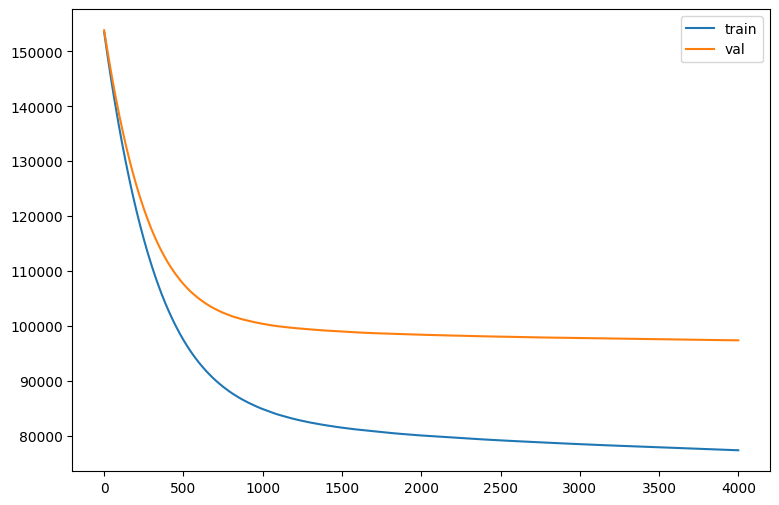

WMAE = 30539.01
Overfit: 20031.65819486667


In [129]:
model = fit_catboost(
    features_train[selected_features],
    features_val[selected_features], 
    target_train,
    target_val, 
    selected_features_cat, 
    4000, 0.002,
    train_weight = w_train,
    val_weight = w_val
)
    
plt.figure(figsize=(9, 6))
plt.plot(range(0,len(model.evals_result_['learn']['RMSE'])),model.evals_result_['learn']['RMSE'], label = 'train')
plt.plot(range(0,len(model.evals_result_['validation']['RMSE'])),model.evals_result_['validation']['RMSE'], label = 'val')
plt.legend()
plt.show()

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val[selected_features]), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

Text(0.5, 1.0, 'Residual Plot')

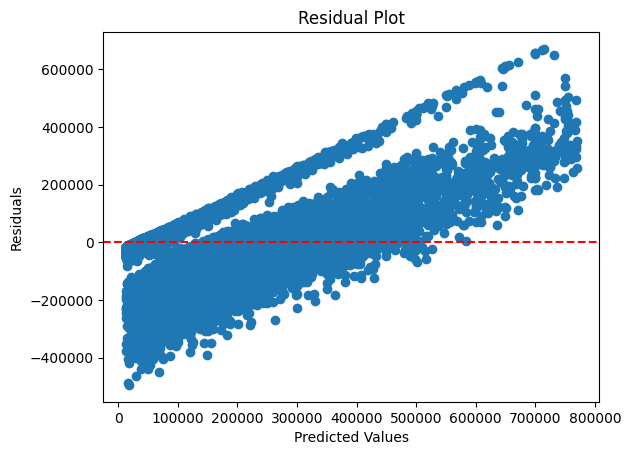

In [130]:
# Plot Residuals
residuals = target_val - model.predict(features_val[selected_features])
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

/opt/conda/lib/python3.10/site-packages/shap/plots/_beeswarm.py:960: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



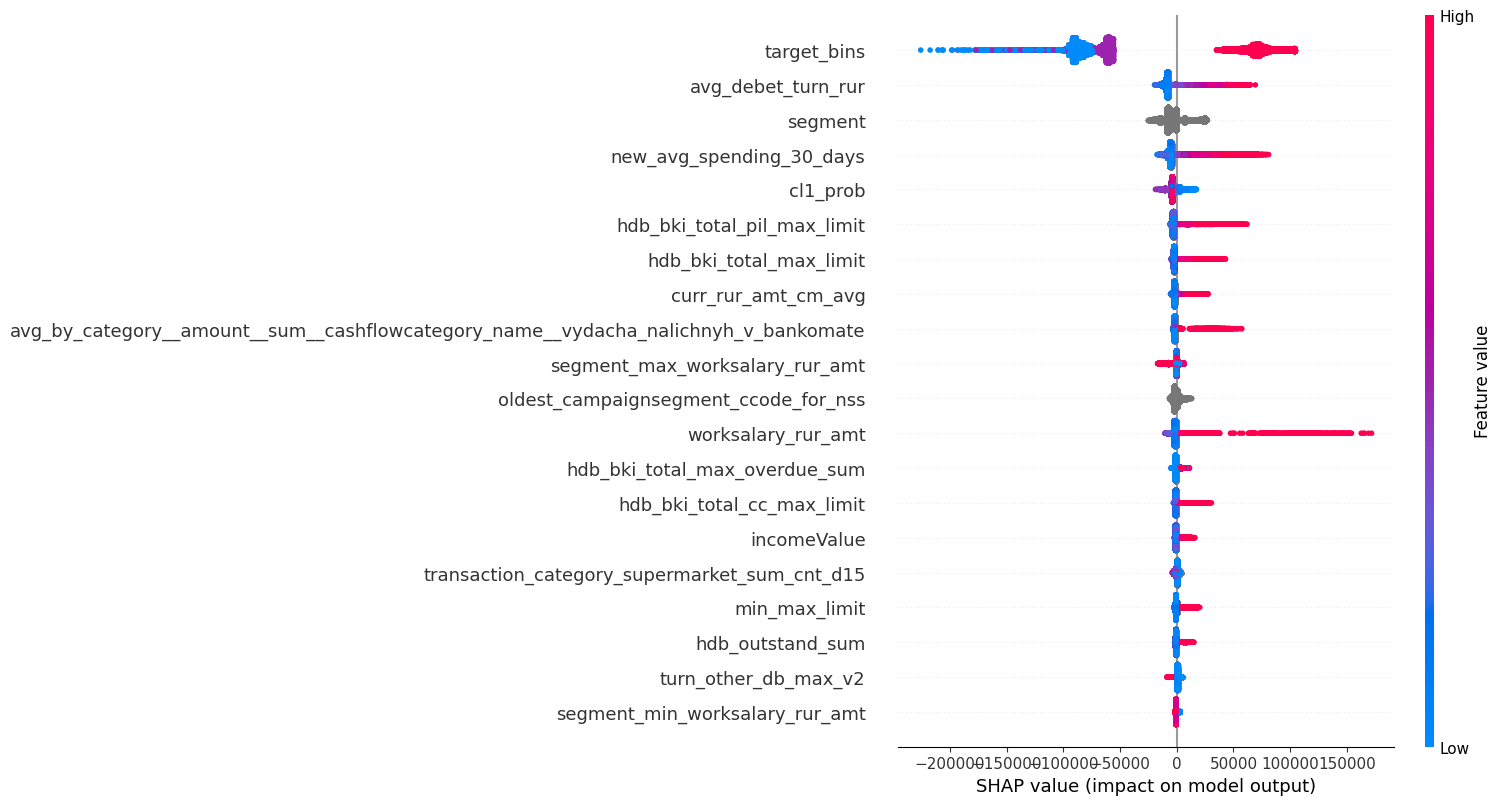

In [131]:
shap_values = (
    shap
    .TreeExplainer(model)
    .shap_values(features_val[selected_features])
)
shap.summary_plot(shap_values, features_val[selected_features])

# Гиперпараметры

### Подбираем lr

In [37]:
def objective(trial):
    params = {
        'iterations': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.06, step = 0.005)
    }
    
    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        random_state=42,
        cat_features = selected_features_cat,
        task_type='GPU',
        early_stopping_rounds=50,
        silent=True
    )
    model.fit(features_train[selected_features], target_train)
    predictions = model.predict(features_val[selected_features])
    rmse = mean_squared_error(target_val, predictions, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(
    objective,
    n_trials=10
)

[I 2024-02-23 09:05:48,772] A new study created in memory with name: no-name-86e467eb-7bd7-464b-80d3-87c81168c7a5
[I 2024-02-23 09:06:25,841] Trial 0 finished with value: 57818.20278406211 and parameters: {'learning_rate': 0.02}. Best is trial 0 with value: 57818.20278406211.
[I 2024-02-23 09:07:04,708] Trial 1 finished with value: 57498.34792300276 and parameters: {'learning_rate': 0.049999999999999996}. Best is trial 1 with value: 57498.34792300276.
[I 2024-02-23 09:07:41,925] Trial 2 finished with value: 58542.91122046426 and parameters: {'learning_rate': 0.005}. Best is trial 1 with value: 57498.34792300276.
[I 2024-02-23 09:08:20,087] Trial 3 finished with value: 57581.921682947985 and parameters: {'learning_rate': 0.04}. Best is trial 1 with value: 57498.34792300276.
[I 2024-02-23 09:08:56,838] Trial 4 finished with value: 58532.33830523723 and parameters: {'learning_rate': 0.005}. Best is trial 1 with value: 57498.34792300276.
[I 2024-02-23 09:09:33,332] Trial 5 finished with va

### Подбираем  остальные

In [134]:
def objective(trial):
    params = {
        'iterations': 4000, 
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.002, step=0.00025),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 6.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100)
    }
    
    model = CatBoostRegressor(
        **params,
        loss_function='RMSE',
        random_state=42,
        cat_features = selected_features_cat,
        task_type='GPU',
        early_stopping_rounds=30,
        silent=True
    )
    model.fit(
        features_train[selected_features],
        target_train,
        sample_weight=w_train
    )
    predictions = model.predict(features_val[selected_features])
    rmse = mean_squared_error(
        target_val, 
        predictions, 
        squared=False,
        sample_weight=w_val
    )
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(
    objective,
    n_trials=30
)

print('Best hyperparameters:', study.best_params)
print('Best score:', study.best_value)

[I 2024-02-25 08:28:35,070] A new study created in memory with name: no-name-3781753e-1418-461d-b0ea-459defe2c45a
[I 2024-02-25 08:29:21,270] Trial 0 finished with value: 98840.40749161382 and parameters: {'learning_rate': 0.00175, 'depth': 4, 'l2_leaf_reg': 2.5536915520274386, 'random_strength': 2.837337229277708, 'min_data_in_leaf': 96}. Best is trial 0 with value: 98840.40749161382.
[I 2024-02-25 08:30:07,872] Trial 1 finished with value: 100076.20520927056 and parameters: {'learning_rate': 0.001, 'depth': 4, 'l2_leaf_reg': 3.1737301624364527, 'random_strength': 4.8055319921851405, 'min_data_in_leaf': 15}. Best is trial 0 with value: 98840.40749161382.
[I 2024-02-25 08:33:07,948] Trial 2 finished with value: 98298.0068790797 and parameters: {'learning_rate': 0.00125, 'depth': 10, 'l2_leaf_reg': 8.394702334086551, 'random_strength': 5.451172607465464, 'min_data_in_leaf': 62}. Best is trial 2 with value: 98298.0068790797.
[I 2024-02-25 08:34:22,300] Trial 3 finished with value: 99123.

Best hyperparameters: {'learning_rate': 0.002, 'depth': 9, 'l2_leaf_reg': 6.950148124223717, 'random_strength': 0.2434007323062295, 'min_data_in_leaf': 54}
Best score: 96677.29299971373


# Обучение модели на гиперпараметрах

0:	learn: 153514.6604931	test: 153858.3620804	best: 153858.3620804 (0)	total: 47.4ms	remaining: 3m 9s
100:	learn: 135115.9734512	test: 137574.6731028	best: 137574.6731028 (100)	total: 3.42s	remaining: 2m 11s
200:	learn: 120969.0970065	test: 125624.4376509	best: 125624.4376509 (200)	total: 6.49s	remaining: 2m 2s
300:	learn: 110228.0620621	test: 117042.5467803	best: 117042.5467803 (300)	total: 9.52s	remaining: 1m 56s
400:	learn: 102155.6227685	test: 110994.3835024	best: 110994.3835024 (400)	total: 12.6s	remaining: 1m 53s
500:	learn: 96152.2366531	test: 106822.0696417	best: 106822.0696417 (500)	total: 15.7s	remaining: 1m 49s
600:	learn: 91708.1589190	test: 103996.1232194	best: 103996.1232194 (600)	total: 18.6s	remaining: 1m 45s
700:	learn: 88409.5849367	test: 102091.8036268	best: 102091.8036268 (700)	total: 21.6s	remaining: 1m 41s
800:	learn: 85936.7899518	test: 100820.4123363	best: 100820.4123363 (800)	total: 24.6s	remaining: 1m 38s
900:	learn: 84079.1437562	test: 99972.0709554	best: 999

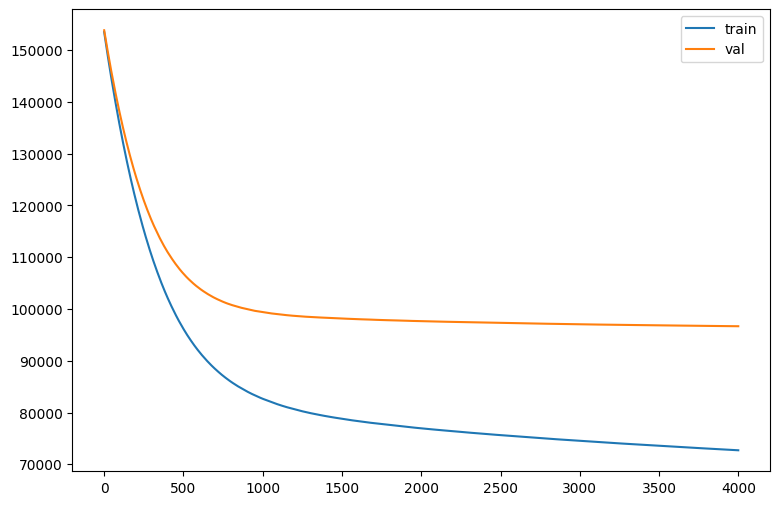

WMAE = 30112.06
Overfit: 23969.521220557508


In [136]:
pool_train = Pool(
    features_train[selected_features],
    target_train,
    weight=w_train,
    cat_features = selected_features_cat
)

pool_val = Pool(
    features_val[selected_features],
    target_val,
    weight = w_val,
    cat_features = selected_features_cat
)

model = CatBoostRegressor(
    iterations = 4000,
    **study.best_params,
    loss_function='RMSE',
    random_seed=42,
    task_type='GPU',
    early_stopping_rounds=50
)

model.fit(
    pool_train,
    verbose=100,
    eval_set=pool_val
)

plt.figure(figsize=(9, 6))
plt.plot(range(0,len(model.evals_result_['learn']['RMSE'])),model.evals_result_['learn']['RMSE'], label = 'train')
plt.plot(range(0,len(model.evals_result_['validation']['RMSE'])),model.evals_result_['validation']['RMSE'], label = 'val')
plt.legend()
plt.show()

WMAE = weighted_mean_absolute_error(target_val, model.predict(features_val[selected_features]), w_val)
print(f"WMAE = {WMAE:.2f}")
print(f"Overfit: {model.evals_result_['validation']['RMSE'][-1] - model.evals_result_['learn']['RMSE'][-1]}")

Text(0.5, 1.0, 'Residual Plot')

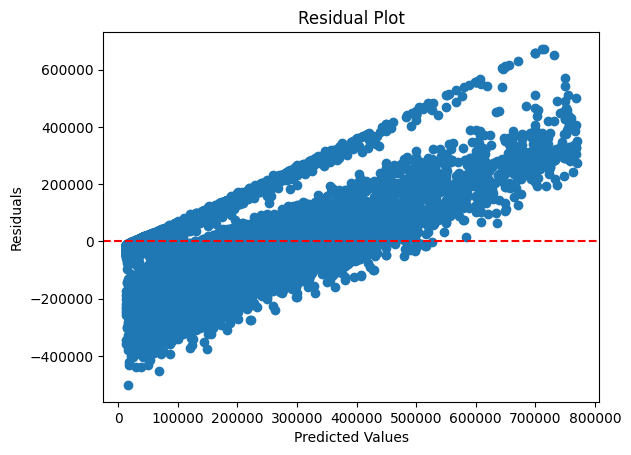

In [138]:
# Plot Residuals
residuals = target_val - model.predict(features_val[selected_features])
plt.scatter(target_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Обучение и сохранении итоговой модели

In [ ]:
# {'learning_rate': 0.00292469988146639, 'depth': 10, 'l2_leaf_reg': 2.1055526882402065, 'random_strength': 0.12279696347870717, 'min_data_in_leaf': 100} 1
 
# {'learning_rate': 0.0029749649001435145, 'depth': 10, 'l2_leaf_reg': 2.8532576045668883, 'random_strength': 0.6646528337974863, 'min_data_in_leaf': 96} 2

#  {'learning_rate': 0.0028346204461265827, 'depth': 10, 'l2_leaf_reg': 3.2577297891972914, 'random_strength': 0.5595635001511284, 'min_data_in_leaf': 97} 3

In [141]:
clf_model_1 = CatBoostClassifier().load_model('/kaggle/input/alfa-clf-models/full_3cl_333_666_model_clf_1')
clf_model_2 = CatBoostClassifier().load_model('/kaggle/input/alfa-clf-models/full_3cl_333_666_model_clf_2')
clf_model_3 = CatBoostClassifier().load_model('/kaggle/input/alfa-clf-models/full_3cl_333_666_model_clf_3')

with open('/kaggle/input/alfa-clf-models/3cl_33_67_label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

full_train_df['target_bins'] = None
full_train_df.loc[full_train_df['target'] <= full_train_df['target'].quantile(0.333), 'target_bins'] = 'bin_0'
full_train_df.loc[
    (full_train_df['target'] > full_train_df['target'].quantile(0.333))
    & (full_train_df['target'] <= full_train_df['target'].quantile(0.666)), 
    'target_bins'
] = 'bin_1'
full_train_df.loc[full_train_df['target'] > full_train_df['target'].quantile(0.666), 'target_bins'] = 'bin_2'
full_train_df['target_bins'] = le.transform(full_train_df['target_bins'])

mean_pred_full = np.mean(
    np.concatenate(
        (
            clf_model_1.predict_proba(full_train_df[clf_model_1.feature_names_]).reshape(1, -1, 3),
            clf_model_2.predict_proba(full_train_df[clf_model_2.feature_names_]).reshape(1, -1, 3),
            clf_model_3.predict_proba(full_train_df[clf_model_3.feature_names_]).reshape(1, -1, 3)
        )
    ),
    axis=0
)

full_train_df['cl0_prob'] = mean_pred_full[:,0]
full_train_df['cl1_prob'] = mean_pred_full[:,1]
full_train_df['cl2_prob'] = mean_pred_full[:,2]

In [148]:
params1 = {'learning_rate': 0.002, 'depth': 9, 'l2_leaf_reg': 6.950148124223717, 'random_strength': 0.2434007323062295, 'min_data_in_leaf': 54}
params2 = {'learning_rate': 0.002, 'depth': 10, 'l2_leaf_reg': 3.380677035917464, 'random_strength': 0.7795273485098911, 'min_data_in_leaf': 90}
params3 = {'learning_rate': 0.00175, 'depth': 10, 'l2_leaf_reg': 0.1885674624753757, 'random_strength': 0.8365880030840178, 'min_data_in_leaf': 100}

pool_train = Pool(
    full_train_df[selected_features],
    full_train_df['target'],
    weight = full_train_df['w'],
    cat_features = selected_features_cat
)

model = CatBoostRegressor(
    iterations = 4000,
    **params1,
    loss_function='RMSE',
    random_seed=42,
    task_type='GPU',
    early_stopping_rounds=50
)

model.fit(
    pool_train,
    verbose=100
)

0:	learn: 153610.0475918	total: 54.2ms	remaining: 3m 36s
100:	learn: 135119.7699781	total: 3.28s	remaining: 2m 6s
200:	learn: 120917.6857315	total: 6.36s	remaining: 2m
300:	learn: 110174.5999836	total: 9.5s	remaining: 1m 56s
400:	learn: 102123.9138754	total: 12.6s	remaining: 1m 53s
500:	learn: 96153.9531074	total: 15.7s	remaining: 1m 49s
600:	learn: 91748.5759213	total: 18.9s	remaining: 1m 46s
700:	learn: 88489.9643780	total: 22s	remaining: 1m 43s
800:	learn: 86071.5137877	total: 25.3s	remaining: 1m 41s
900:	learn: 84253.5205232	total: 28.4s	remaining: 1m 37s
1000:	learn: 82871.0455666	total: 31.4s	remaining: 1m 34s
1100:	learn: 81801.5871001	total: 34.5s	remaining: 1m 30s
1200:	learn: 80942.9596652	total: 37.6s	remaining: 1m 27s
1300:	learn: 80264.2247611	total: 40.6s	remaining: 1m 24s
1400:	learn: 79704.8514311	total: 43.6s	remaining: 1m 20s
1500:	learn: 79235.1408190	total: 46.6s	remaining: 1m 17s
1600:	learn: 78831.3845995	total: 49.7s	remaining: 1m 14s
1700:	learn: 78475.0630011	t

In [149]:
model.save_model('/kaggle/working/full_3cl_333_666_model_reg_v2_1')